In [26]:
# importing required libraries 
import time
import numpy as np
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

In [2]:
EPOCHS = 5
BATCH_SIZE = 32
LR = 1e-6

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# 学習データの準備
from torchtext.datasets import AG_NEWS
train_iter, test_iter = AG_NEWS()
df = pd.DataFrame([item for item in train_iter], columns=['label', 'text'])
df

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."
...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...
119996,2,Renteria signing a top-shelf deal Red Sox gene...
119997,2,Saban not going to Dolphins yet The Miami Dolp...
119998,2,Today's NFL games PITTSBURGH at NY GIANTS Time...


<Axes: xlabel='label'>

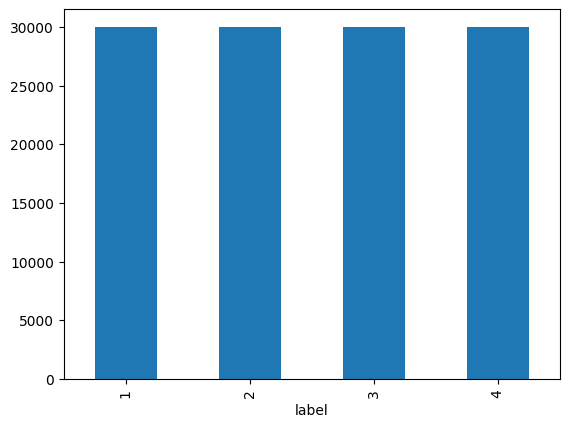

In [5]:
df.groupby(['label']).size().plot.bar()

In [6]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

bert_input = tokenizer(df['text'][0], padding='max_length', max_length = 128, truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[  101,  6250,  1457,   119, 10169,   140,  9598,  4388, 14000,  1103,
          2117,   113, 11336, 27603,   114, 11336, 27603,   118,  6373,   118,
         18275,  1116,   117,  6250,  1715,   112,   188,   173, 11129,  1979,
           165,  1467,  1104, 18737,   118,   172,  5730,  4724,   117,  1132,
          3195,  2448,  1254,   119,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

2023-06-06 09:35:43.285696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 09:35:44.183868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[CLS] Wall St. Bears Claw Back Into the Black ( Reuters ) Reuters - Short - sellers, Wall Street's dwindling \ band of ultra - cynics, are seeing green again. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [7]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
print(len(df_train), len(df_val), len(df_test))

96000 12000 12000


In [8]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

model = BertClassifier().to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
from torchtext.transforms import Sequential, ToTensor
text_transform = Sequential(
    ToTensor()
);

def collate_batch(batch):
    labels = torch.Tensor([ele[0] for ele in batch])
    texts = tokenizer([ele[1] for ele in batch], padding='max_length', max_length = 128, truncation=True, return_tensors="pt") 
    return texts, labels

train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_batch)

train_len = len(list(train_iter))
test_len = len(list(test_iter))

In [27]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr= LR)

for epoch_num in range(EPOCHS):

    total_acc_train = []
    total_loss_train = []
    total_acc_val = []
    total_loss_val = []

    time_s = time.perf_counter()
    
    for i, (train_input, train_label) in enumerate(train_dataloader):

        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        model.zero_grad()
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_label.long())
        total_loss_train.append(batch_loss.item())
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train.append(acc)

        batch_loss.backward()
        optimizer.step()

        print(f"epoch:{epoch_num+1}({(i + 1) / (train_len / BATCH_SIZE):.2%}) | Train Loss: {np.mean(total_loss_train): .3f}  Train Accuracy: {np.mean(total_acc_train): .3f} | Elapsed: {(time.perf_counter() - time_s):.1f}s", end='\r')

    print()
    time_s = time.perf_counter()

    with torch.no_grad():

        for i, (val_input, val_label) in enumerate(val_dataloader):

            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, val_label.long())
            total_loss_val.append(batch_loss.item())
            
            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val.append(acc)

            print(f"epoch:{epoch_num+1}({(i + 1) / (test_len / BATCH_SIZE):.2%}) | Train Loss: {np.mean(total_loss_val): .3f}  Train Accuracy: {np.mean(total_acc_val): .3f} | Elapsed: {(time.perf_counter() - time_s):.1f}s", end='\r')
    print()

epoch:1(100.00%) | Train Loss:  0.202  Train Accuracy:  29.914 | Elapsed: 1652.7s
epoch:1(1578.95%) | Train Loss:  0.211  Train Accuracy:  29.798 | Elapsed: 40.1s
epoch:2(100.00%) | Train Loss:  0.170  Train Accuracy:  30.253 | Elapsed: 1666.1s
epoch:2(1578.95%) | Train Loss:  0.198  Train Accuracy:  29.903 | Elapsed: 40.0s
epoch:3(100.00%) | Train Loss:  0.145  Train Accuracy:  30.511 | Elapsed: 1668.0s
epoch:3(1578.95%) | Train Loss:  0.194  Train Accuracy:  29.933 | Elapsed: 40.0s
epoch:4(100.00%) | Train Loss:  0.124  Train Accuracy:  30.752 | Elapsed: 1670.0s
epoch:4(1578.95%) | Train Loss:  0.197  Train Accuracy:  29.891 | Elapsed: 39.4s
epoch:5(100.00%) | Train Loss:  0.103  Train Accuracy:  30.986 | Elapsed: 1805.0s
epoch:5(1578.95%) | Train Loss:  0.208  Train Accuracy:  29.878 | Elapsed: 43.2s


In [36]:
torch.save(model, '../models/BertClassifier_AG_NEWS.pth')

In [41]:
with torch.no_grad():
    model.eval()
    val_input, val_label = next(iter(val_dataloader))
    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask)

results = [(tokenizer.decode(input_id[i]), val_label[i].item(), pred.argmax().item()) for i, pred in enumerate(output)]
pd.set_option('display.max_colwidth', 500)
df = pd.DataFrame(results, columns=['text', 'label', 'pred'])
df

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


,text,label,pred
0,[CLS] Fears for T N pension after talks Unions representing workers at Turner Newall say they are'disappointed'after talks with stricken parent firm Federal Mogul. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P...,3.0,3
1,"[CLS] The Race is On : Second Private Team Sets Launch Date for Human Spaceflight ( SPACE. com ) SPACE. com - TORONTO, Canada - - A second \ team of rocketeers competing for the # 36 ; 10 million Ansari X Prize, a contest for \ privately funded suborbital space flight, has officially announced the first \ launch date for its manned rocket. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...",4.0,4
2,"[CLS] Ky. Company Wins Grant to Study Peptides ( AP ) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]...",4.0,4
3,"[CLS] Prediction Unit Helps Forecast Wildfires ( AP ) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [...",4.0,4
4,"[CLS] Calif. Aims to Limit Farm - Related Smog ( AP ) AP - Southern California's smog - fighting agency went after emissions of the bovine variety Friday, adopting the nation's first rules to reduce air pollution from dairy cow manure. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P...",4.0,4
5,"[CLS] Open Letter Against British Copyright Indoctrination in Schools The British Department for Education and Skills ( DfES ) recently launched a "" Music Manifesto "" campaign, with the ostensible intention of educating the next generation of British musicians. Unfortunately, they also teamed up with the music industry ( EMI, and various artists ) to make this popular. EMI has apparently negotiated their end well, so that children in our schools will now be indoctrinated about the illegality...",4.0,4
6,"[CLS] Loosing the War on Terrorism \ \ "" Sven Jaschan, self - confessed author of the Netsky and Sasser viruses, is \ responsible for 70 percent of virus infections in 2004, according to a six - month \ virus roundup published Wednesday by antivirus company Sophos. "" \ \ "" The 18 - year - old Jaschan was taken into custody in Germany in May by police who \ said he had admitted programming both the Netsky and Sasser worms, something \ experts at Microsoft confirmed. ( A Microsoft antivirus re...",4.0,4
7,"[CLS] FOAFKey : FOAF, PGP, Key Distribution, and Bloom Filters \ \ FOAF / LOAF and bloom filters have a lot of interesting properties for social \ network and whitelist distribution. \ \ I think we can go one level higher though and include GPG / OpenPGP key \ fingerpring distribution in the FOAF file for simple web - of - trust based key \ distribution. \ \ What if we used FOAF and included the PGP key 